#  INIT

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/cytof_data/')
sys.path.append('../experiments/')

In [2]:
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments

In [3]:
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing

from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [4]:
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

from cellMix_coordinator import CellMixCoordinator

# calc cell proportions - LFQ

## mixture & cell specific data & proportions data

In [5]:
data_loader = DataLoader(mass_spec_path=os.path.abspath('../data/20190801_filtered_imputed_data.csv'),
                         protein_profile_path = os.path.abspath('../data/20150718_Cerberus_proteinGroups.txt'),as_csv = True)
data_factory = DataFactory(data_loader)
# profile_data,profile_data_relvent_data = data_factory.build_cell_specific_profile()
# mixtures,mixtures_relvent_data = data_factory.build_mixture_data()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
ms = data_loader.get_mass_spec_data()
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(relvent_data=[pb for pb in ms.columns if "_v" in pb],relvent_columns=["Majority protein IDs"],auto_filter_by=False,log2_transformation=True)

In [7]:
relvent_data = ['LFQ intensity NOT_BCellmemory_01', 'LFQ intensity NOT_BCellnaive_01', 'LFQ intensity NOT_BCellplasma_01', 'LFQ intensity NOT_CD4TCellmTregs_01',
 'LFQ intensity NOT_CD4TCellnaive_01', 'LFQ intensity NOT_CD4TCellnTregs_01', 'LFQ intensity NOT_CD4TCellTcm_01', 'LFQ intensity NOT_CD4TCellTem_01',
 'LFQ intensity NOT_CD4TCellTemra_01', 'LFQ intensity NOT_CD4TCellTh1_01', 'LFQ intensity NOT_CD4TCellTh17_01', 'LFQ intensity NOT_CD4TCellTh2_01',
 'LFQ intensity NOT_CD8TCellnaive_01', 'LFQ intensity NOT_CD8TCellTcm_01', 'LFQ intensity NOT_CD8TCellTem_01', 'LFQ intensity NOT_CD8TCellTemra_01',
 'LFQ intensity NOT_DendriticCD1c_01', 'LFQ intensity NOT_DendriticCD304_01', 'LFQ intensity NOT_GranulocytesBasophil_01', 'LFQ intensity NOT_Granulocyteseosinophils_01',
 'LFQ intensity NOT_Granulocytesneutrophils_01', 'LFQ intensity NOT_Monocytesclassical_01', 'LFQ intensity NOT_Monocytesintermediate_01',
 'LFQ intensity NOT_Monocytesnonclassical_01', 'LFQ intensity NOT_NKCellsCD56bright_01', 'LFQ intensity NOT_NKCellsCD56dim_01',
 'LFQ intensity NOT_Erythrocytes_01', 'LFQ intensity NOT_Thrombocytes_01']

profile_data,profile_data_relvent_data = data_factory.build_cell_specific_profile(auto_filter_by=False,relvent_data=relvent_data,relvent_columns=["Majority protein IDs"])

cell_proportions_df = pd.DataFrame(index = ['LFQ intensity NOT_CD4TCellTcm_01','LFQ intensity NOT_BCellmemory_01','LFQ intensity NOT_Monocytesnonclassical_01'],
                                   columns = list(range(1,9)),
                                   data =np.array(((100,0,0),(0,100,0),(0,0,100),(33,33,33),(25,25,50),(25,50,25),(50,25,25),(47.5,47.5,5.0))).T)

## build A ,X and B 

In [8]:
index_func = lambda x:x.split(';')[0]
_profile_data,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data,mixtures,index_func=index_func)
A = _profile_data[profile_data_relvent_data]
B = _mixtures[mixtures_relvent_data]

X = cell_proportions_df

A = A.rename({f:f.split('LFQ intensity ')[1] for f in A.columns},axis=1)

## models

../infras/cytof_data\cytof_cell_count_infra.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  cytof_cluster_no_antigens["featureID"] = cytof_cluster_no_antigens["featureID"].str.slice(3)


--------------margin quantile-----------------


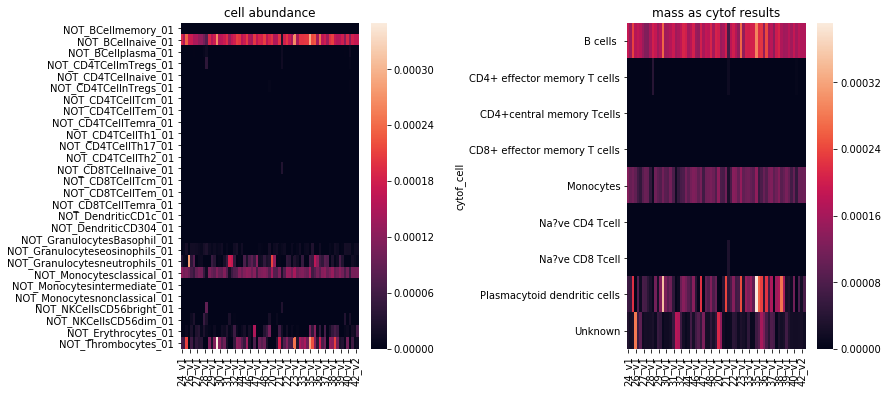

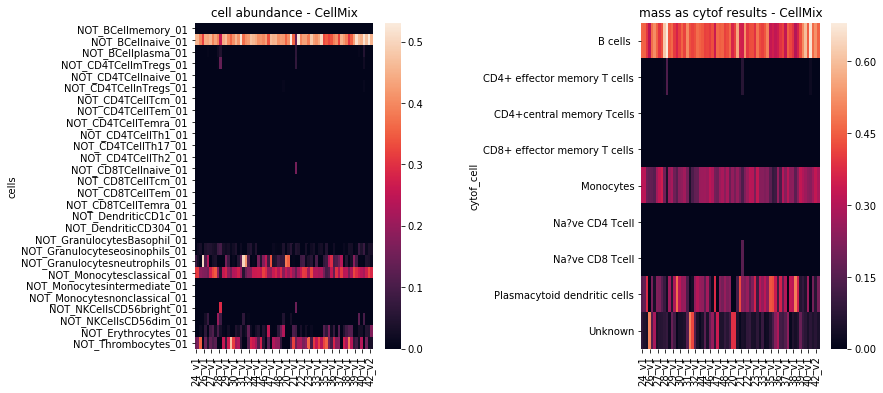

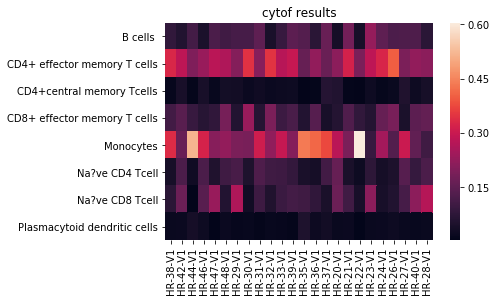

--------------under quantile-----------------


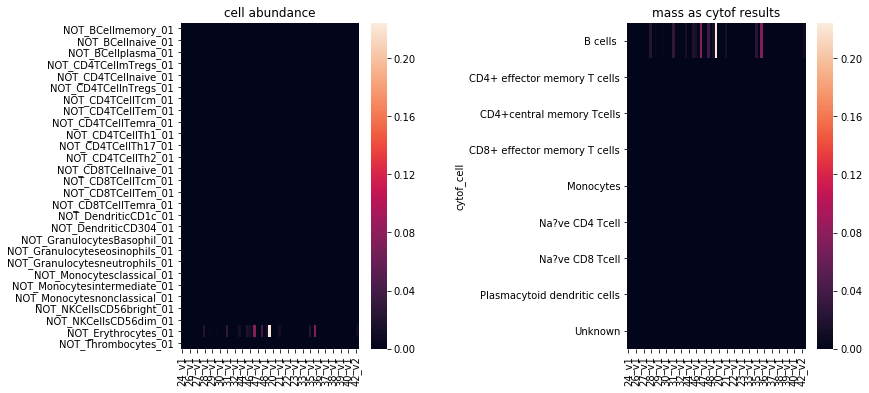

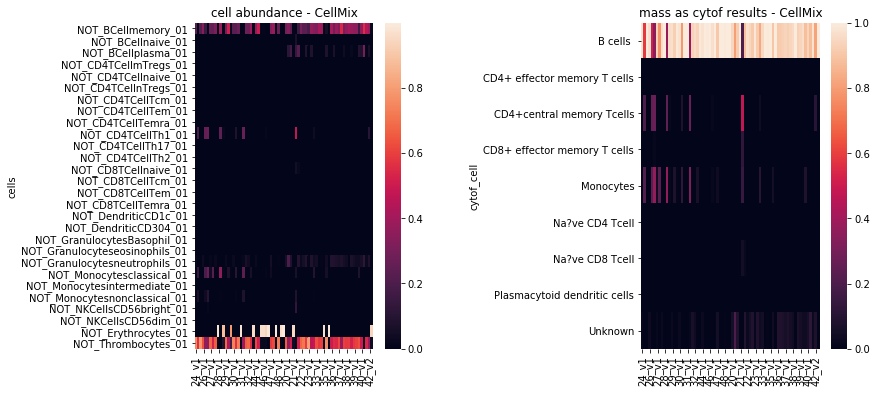

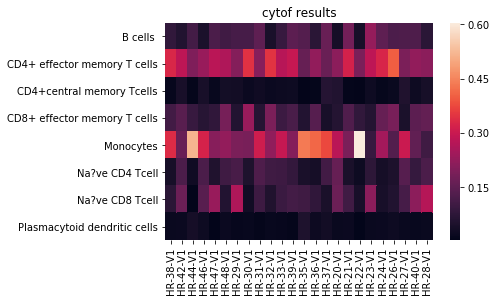

-----------------entropy--------------------


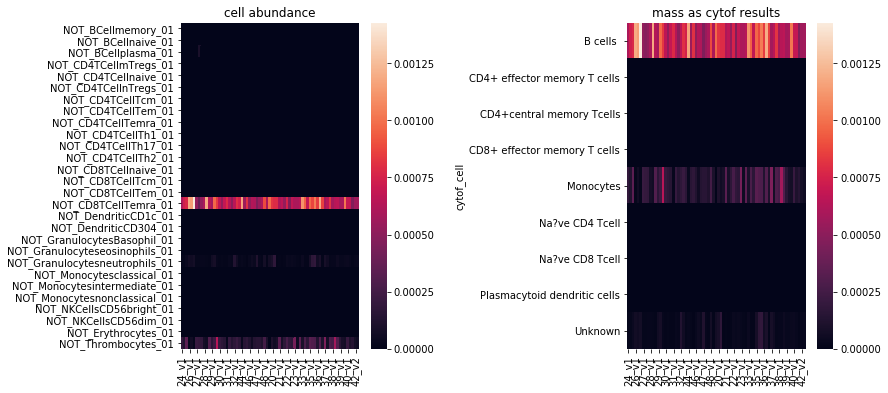

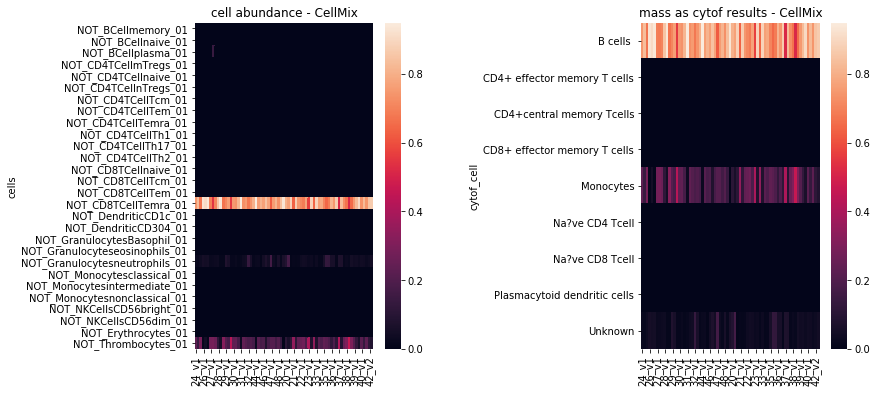

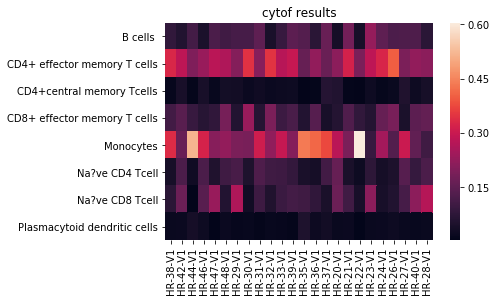

In [9]:
cell_prop = CellProportionsExperiments()
cell_prop.run_models_over_preProcess(["margin quantile","under quantile","entropy"],A,B,None,True,True,True)

# calc cell proportions - iBAQ

## mixture & cell specific & proportions data

In [10]:
relvent_data = ['iBAQ NOT_BCellmemory_01', 'iBAQ NOT_BCellnaive_01', 'iBAQ NOT_BCellplasma_01', 'iBAQ NOT_CD4TCellmTregs_01', 'iBAQ NOT_CD4TCellnaive_01',
 'iBAQ NOT_CD4TCellnTregs_01', 'iBAQ NOT_CD4TCellTcm_01', 'iBAQ NOT_CD4TCellTem_01', 'iBAQ NOT_CD4TCellTemra_01', 'iBAQ NOT_CD4TCellTh1_01', 'iBAQ NOT_CD4TCellTh17_01',
 'iBAQ NOT_CD4TCellTh2_01', 'iBAQ NOT_CD8TCellnaive_01', 'iBAQ NOT_CD8TCellTcm_01', 'iBAQ NOT_CD8TCellTem_01', 'iBAQ NOT_CD8TCellTemra_01', 'iBAQ NOT_DendriticCD1c_01',
 'iBAQ NOT_DendriticCD304_01', 'iBAQ NOT_Erythrocytes_01', 'iBAQ NOT_GranulocytesBasophil_01', 'iBAQ NOT_Granulocyteseosinophils_01', 'iBAQ NOT_Granulocytesneutrophils_01',
 'iBAQ NOT_Monocytesclassical_01', 'iBAQ NOT_Monocytesintermediate_01', 'iBAQ NOT_Monocytesnonclassical_01', 'iBAQ NOT_NKCellsCD56bright_01', 'iBAQ NOT_NKCellsCD56dim_01',
 'iBAQ NOT_Thrombocytes_01']

data_factory = DataFactory(data_loader)
profile_data,profile_data_relvent_data = data_factory.build_cell_specific_profile(auto_filter_by=False,relvent_data=relvent_data,relvent_columns=["Majority protein IDs"])
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(relvent_data=[pb for pb in ms.columns if "_v" in pb],relvent_columns=["Majority protein IDs"],auto_filter_by=False,log2_transformation=True)

cell_proportions_df = pd.DataFrame(index = ['iBAQ NOT_CD4TCellTcm_01','iBAQ NOT_BCellmemory_01','iBAQ NOT_Monocytesnonclassical_01'],
                                   columns = list(range(1,9)),
                                   data =np.array(((100,0,0),(0,100,0),(0,0,100),(33,33,33),(25,25,50),(25,50,25),(50,25,25),(47.5,47.5,5.0))).T)

## build A ,X and B 

In [11]:
index_func = lambda x:x.split(';')[0]
_profile_data,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data,mixtures,index_func=index_func)
A = _profile_data[profile_data_relvent_data]
B = _mixtures[mixtures_relvent_data]

X = cell_proportions_df

X = X.rename({f:f.split('iBAQ ')[1] for f in X.index},axis=0)
X = X.rename({f:'mixture'+str(f) for f in X.columns},axis=1)

A = A.rename({f:f.split('iBAQ ')[1] for f in A.columns},axis=1)

## models

../infras/cytof_data\cytof_cell_count_infra.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  cytof_cluster_no_antigens["featureID"] = cytof_cluster_no_antigens["featureID"].str.slice(3)


--------------margin quantile-----------------


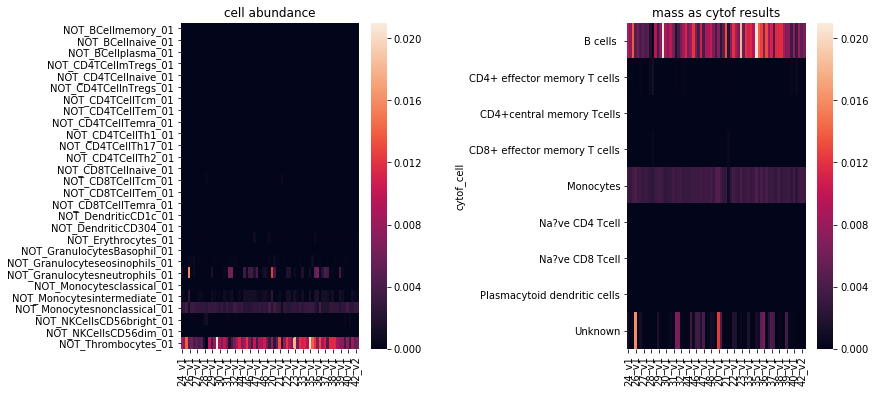

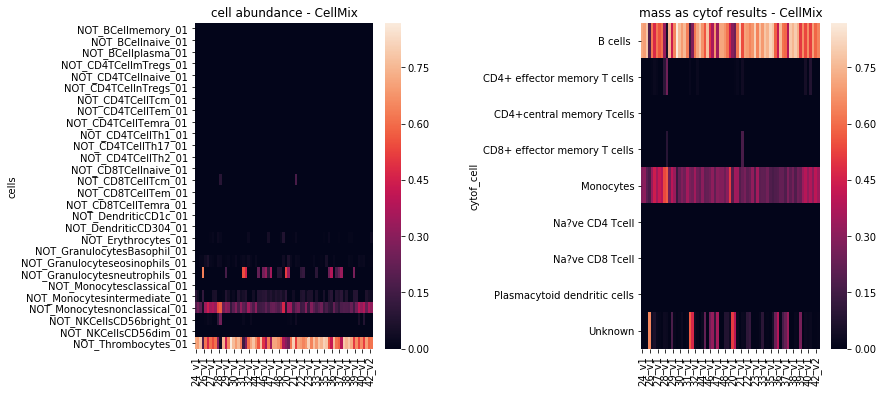

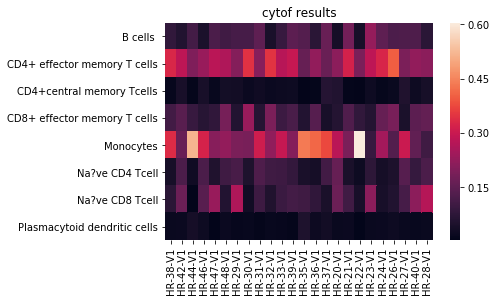

--------------under quantile-----------------


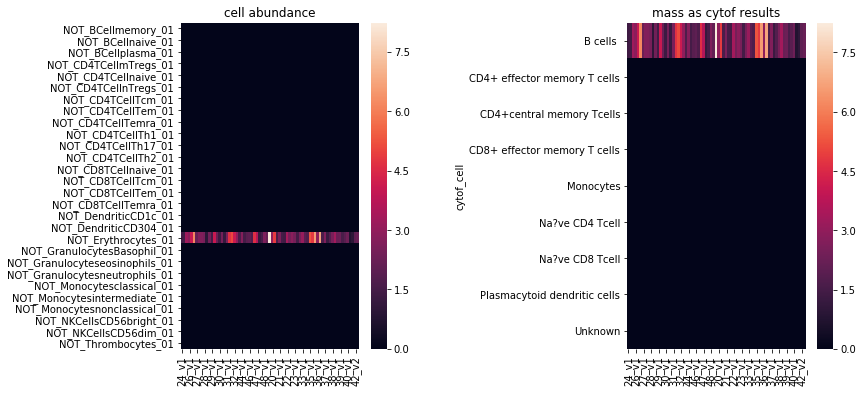

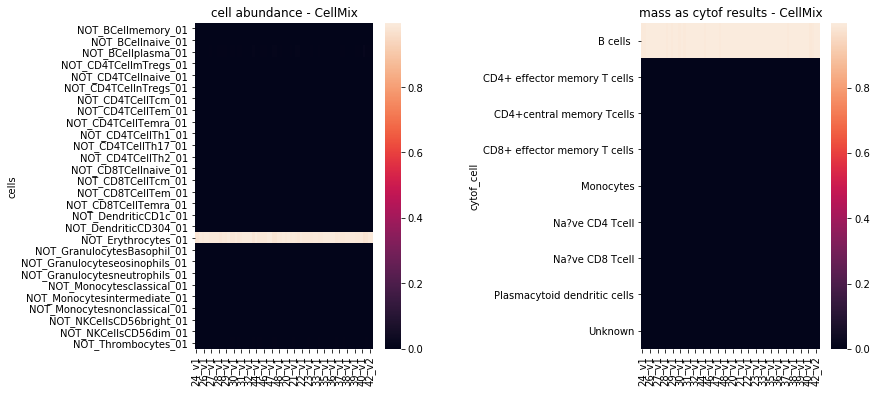

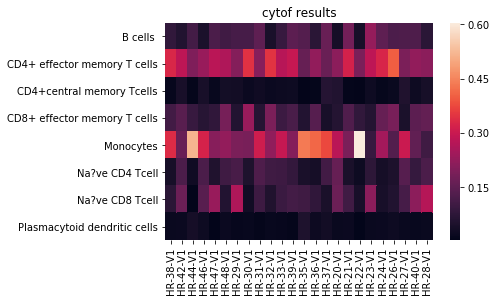

In [12]:
cell_prop = CellProportionsExperiments()
cell_prop.run_models_over_preProcess(["margin quantile","under quantile"],A,B,None,True,True,True)

## entropy base pp

In [13]:
from scipy.stats import entropy
from functools import reduce
cmc = CellMixCoordinator()
_A, _B = PP_proteins.pp_clean_irrelevant_proteins(A, B)


a,b = PP_proteins.pp_entropy_based(_A,_B,50)
cellMax_cell_abundance_over_samples = cmc.cell_prop_with_bash(b, a).rename({"Unnamed: 0": "cells"},
                                                                                         axis=1).set_index("cells")

# calc cell proportions - intensities

## mixture & cell specific & proportions data

In [14]:
relvent_data = ['Intensity NOT_BCellmemory_01', 'Intensity NOT_BCellnaive_01', 'Intensity NOT_BCellplasma_01', 'Intensity NOT_CD4TCellmTregs_01',
 'Intensity NOT_CD4TCellnaive_01', 'Intensity NOT_CD4TCellnTregs_01', 'Intensity NOT_CD4TCellTcm_01', 'Intensity NOT_CD4TCellTem_01',
 'Intensity NOT_CD4TCellTemra_01', 'Intensity NOT_CD4TCellTh1_01', 'Intensity NOT_CD4TCellTh17_01', 'Intensity NOT_CD4TCellTh2_01',
 'Intensity NOT_CD8TCellnaive_01', 'Intensity NOT_CD8TCellTcm_01', 'Intensity NOT_CD8TCellTem_01', 'Intensity NOT_CD8TCellTemra_01',
 'Intensity NOT_DendriticCD1c_01', 'Intensity NOT_DendriticCD304_01', 'Intensity NOT_Erythrocytes_01', 'Intensity NOT_GranulocytesBasophil_01',
 'Intensity NOT_Granulocyteseosinophils_01', 'Intensity NOT_Granulocytesneutrophils_01', 'Intensity NOT_Monocytesclassical_01', 'Intensity NOT_Monocytesintermediate_01',
 'Intensity NOT_Monocytesnonclassical_01', 'Intensity NOT_NKCellsCD56bright_01', 'Intensity NOT_NKCellsCD56dim_01', 'Intensity NOT_Thrombocytes_01']

data_factory = DataFactory(data_loader)
profile_data,profile_data_relvent_data = data_factory.build_cell_specific_profile(auto_filter_by=False,relvent_data=relvent_data,relvent_columns=["Majority protein IDs"])
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(relvent_data=[pb for pb in ms.columns if "_v" in pb],relvent_columns=["Majority protein IDs"],auto_filter_by=False,log2_transformation=True)

cell_proportions_df = pd.DataFrame(index = ['Intensity NOT_CD4TCellTcm_01','Intensity NOT_BCellmemory_01','Intensity NOT_Monocytesnonclassical_01'],
                                   columns = list(range(1,9)),
                                   data =np.array(((100,0,0),(0,100,0),(0,0,100),(33,33,33),(25,25,50),(25,50,25),(50,25,25),(47.5,47.5,5.0))).T)

## build A ,X and B 

In [15]:
index_func = lambda x:x.split(';')[0]
_profile_data,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data,mixtures,index_func=index_func)
A = _profile_data[profile_data_relvent_data]
B = _mixtures[mixtures_relvent_data]

X = cell_proportions_df

A = A.rename({f:f.split('Intensity ')[1] for f in A.columns},axis=1)

## models

../infras/cytof_data\cytof_cell_count_infra.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  cytof_cluster_no_antigens["featureID"] = cytof_cluster_no_antigens["featureID"].str.slice(3)


--------------margin quantile-----------------


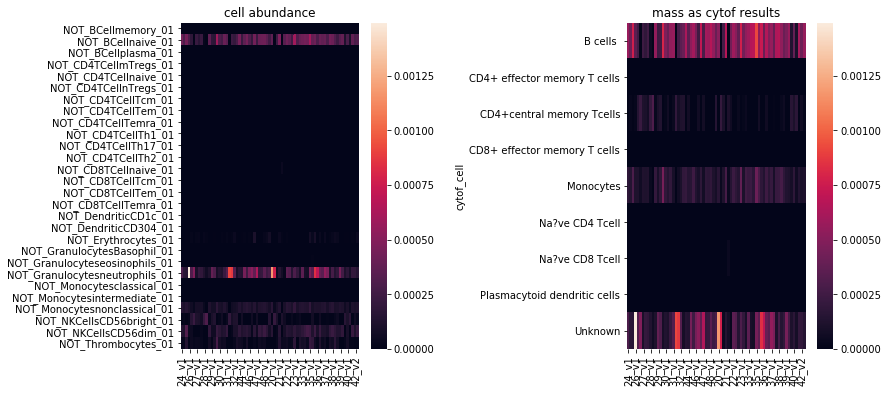

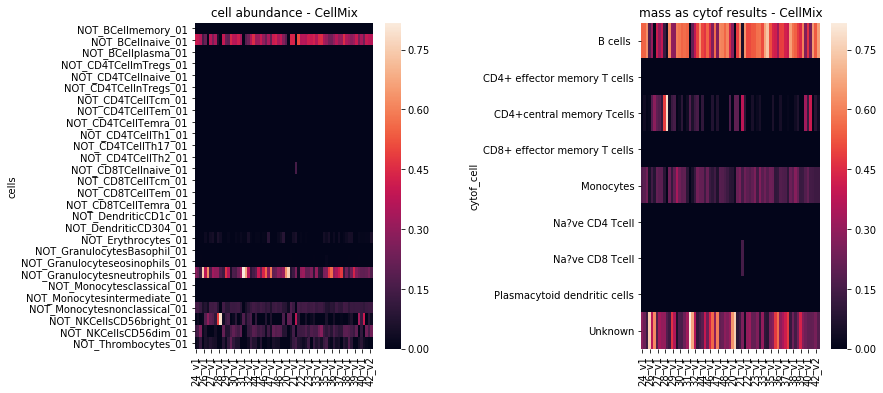

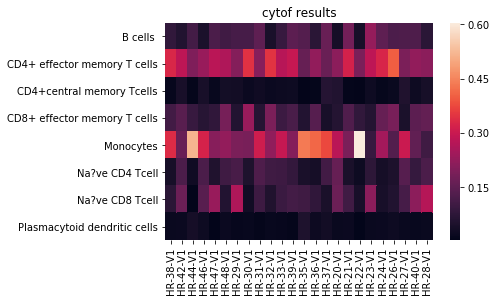

--------------under quantile-----------------


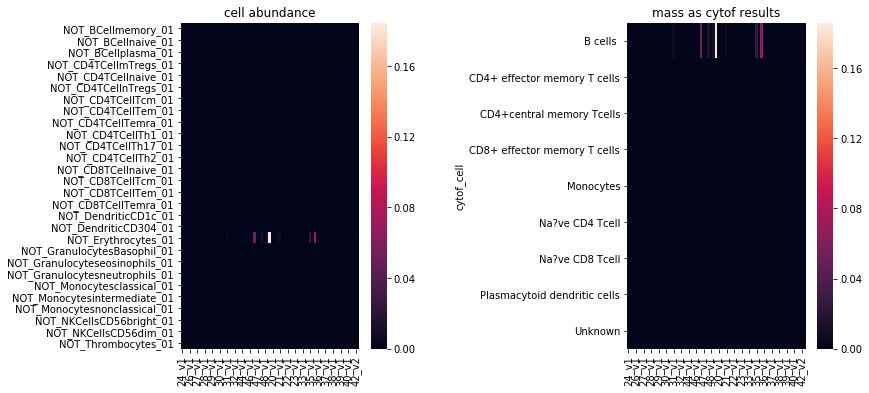

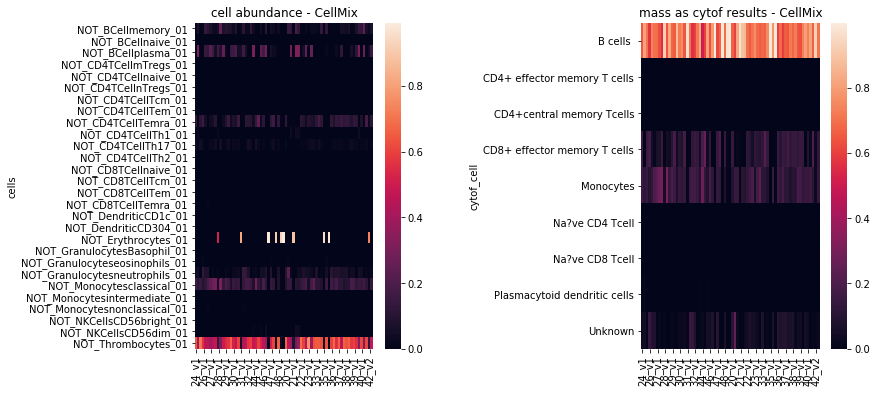

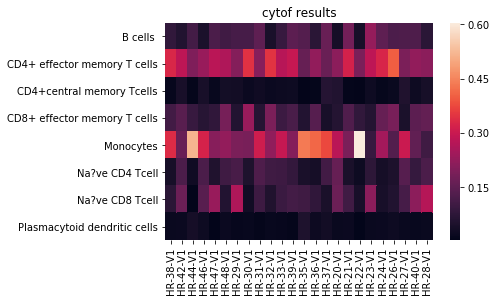

In [16]:
cell_prop = CellProportionsExperiments()
cell_prop.run_models_over_preProcess(["margin quantile","under quantile"],A,B,None,True,True,True)